# The spelled-out intro to neural networks and backpropagation: building micrograd

In [301]:
import math
import random
from symbol import parameters

import numpy as np
import matplotlib.pyplot as plt
from fontTools.ufoLib import layerContentsValidator
%matplotlib inline

In [302]:
def f(x):
    return 3*x**2 - 4*x + 5

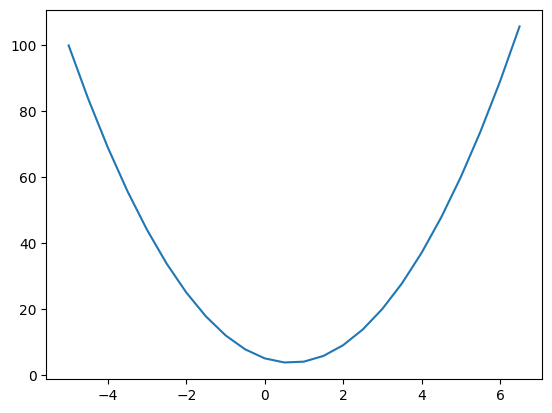

In [303]:

xs = np.arange(-5, 7, 0.5)
ys = f(xs)
plt.figure()
plt.plot(xs, ys)

x1 = 3
x2 = -3
h = 0.2

In [304]:
h = 0.2
x = 3
f(x), f(x+h), (f(x+h) - f(x)) / h

(20, 22.920000000000005, 14.600000000000026)

## Micrograd

In [305]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, power):
        assert isinstance(power, (int, float))
        out = Value(self.data ** power, (self,), f"^{power}")

        def _backward():
            self.grad += power * (self.data ** (power - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        out = self * other ** -1
        out._op = '/'
        return out

    def __neg__(self):  # -self
        return self * (-1)

    def __sub__(self, other):
        out = self + (-other)
        out._op = '-'
        return out

    def __rsub__(self, other):
        return self - other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), _op='exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [306]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, filename=None):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)


    if filename:
        dot.render(filename, cleanup=True)  # cleanup=True removes .gv source file
        print(f"Graph saved to {filename}")

    return dot


In [307]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# set grad
# L.grad = 1
# d.grad = f.data
# f.grad = d.data
# e.grad = f.data
# c.grad = f.data
# a.grad = f.data * b.data
# b.grad = f.data * a.data

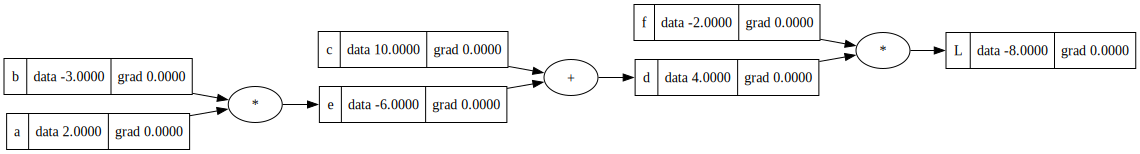

In [308]:
draw_dot(L)

In [309]:
L.backward()

In [310]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data


    print((L2 - L1)/h)

lol()

-4.000000000008441


In [311]:
# optimization
a.data += 0.0001 * a.grad
b.data += 0.0001 * b.grad
c.data += 0.0001 * c.grad
f.data += 0.0001 * f.grad

e = a * b
d = e + c
L = d * f
L.data

-7.992800640096002

In [312]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # total wx + b
        act: Value = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


"""
    Multi layer perceptron
"""


class MLP:
    """
        nouts = [outputFirstLayer, outputSecondLayer, .... outputLastLayer]
    """

    def __init__(self, nin, nouts):
        # total layer including first
        layer_def = [nin] + nouts
        self.layers = [Layer(layer_def[i], layer_def[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    def parameters(self) -> list[Value]:
        return [p for layer in self.layers for p in layer.parameters()]

In [313]:
x_train = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
y_train = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [314]:
# Gradiant decent
for i in range(20):
    # forward pass
    y_pred = [n(x) for x in x_train]
    loss = sum((y_true - y_train)**2 for y_true, y_train in zip(y_pred, y_train))

    # backward pass
    n.zero_grad()
    loss.backward()

    # update params
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f"epoch={i}, loss={loss.data}")

epoch=0, loss=7.896230420460314
epoch=1, loss=7.870226435837562
epoch=2, loss=7.826306275361622
epoch=3, loss=7.741264885005421
epoch=4, loss=7.541992476963727
epoch=5, loss=6.928698139148878
epoch=6, loss=4.558884865361582
epoch=7, loss=3.8659488086662046
epoch=8, loss=3.331385755652232
epoch=9, loss=2.565709337373203
epoch=10, loss=1.1554939883347652
epoch=11, loss=0.6057044309576923
epoch=12, loss=0.3605032952170648
epoch=13, loss=0.24772976579968803
epoch=14, loss=0.18679616794177548
epoch=15, loss=0.14916982795818923
epoch=16, loss=0.12374291290566575
epoch=17, loss=0.10547870408263021
epoch=18, loss=0.09175789268219887
epoch=19, loss=0.08109122288544773


In [ ]:
draw_dot(loss, '/Users/phucnguyen/PyCharmMiscProject/loss')

IndentationError: expected an indented block (3847033720.py, line 3)